In [5]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
import transformers

models_list = dir(transformers)
for x in models_list:
    if "Qwen2VL" in x:
        print(x)

Qwen2VLConfig
Qwen2VLForConditionalGeneration
Qwen2VLImageProcessor
Qwen2VLImageProcessorFast
Qwen2VLModel
Qwen2VLPreTrainedModel
Qwen2VLProcessor
Qwen2VLTextConfig
Qwen2VLTextModel
Qwen2VLVideoProcessor


In [1]:
system_message = """You are a Vision Language Model specialized in interpreting visual data from chart images.
Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.
The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

In [2]:
def format_data(sample):
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": sample["query"],
                },
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": sample["label"][0]}],
        },
    ]

In [3]:
from datasets import load_dataset

dataset_id = "HuggingFaceM4/ChartQA"
train_dataset, eval_dataset, test_dataset = load_dataset(dataset_id, split=["train[:10%]", "val[:10%]", "test[:10%]"])

In [4]:
eval_dataset

Dataset({
    features: ['image', 'query', 'label', 'human_or_machine'],
    num_rows: 192
})

In [5]:
train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

In [6]:
eval_dataset[0]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.\nThe charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x386>},
   {'type': 'text',
    'text': "What's the color of graph with 56 as the highest value?"}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': 'Blue'}]}]

In [1]:
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor

model_id = "Qwen/Qwen2-VL-7B-Instruct"

In [2]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

processor = Qwen2VLProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


In [3]:
from qwen_vl_utils import process_vision_info


def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    text_input = processor.apply_chat_template(
        sample[0:2], tokenize=False, add_generation_prompt=True  # Use the sample without the system message
    )
    image_inputs, _ = process_vision_info(sample)
    
    model_inputs = processor(
        text=[text_input],
        images=image_inputs,
        return_tensors="pt",
    ).to(
        device
    )
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)
    trimmed_generated_ids = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(
        trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    input_height = int((model_inputs['image_grid_thw'][0][1]*14).cpu())
    input_width = int((model_inputs['image_grid_thw'][0][2]*14).cpu())

    return output_text[0], (input_height, input_width)  # Return the first decoded output text

In [4]:
# Example of how to call the method with sample:
# print(train_dataset[0])

# output = generate_text_from_sample(model, processor, train_dataset[0])
# output

In [22]:
from PIL import Image
import json

image_path = "000000006428.jpg"


In [23]:
sample = [
{'role': 'system', 
 'content': [{'type': 'text', 'text': 'You are a Vision Language Model specialized in object detection.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': Image.open(image_path).resize((1024, 1024))},
   {'type': 'text', 'text': '框出所有物体的位置，输出格式是list of json, 每个json包含keys:x1, y1, x2, y2, label'}]}]
out, thw = generate_text_from_sample(model, processor, sample)
out = json.loads("\n".join(out.split("\n")[1:-1]))
print(out, thw)

[{'x1': 0, 'y1': 256, 'x2': 720, 'y2': 688, 'label': 'computer monitor'}, {'x1': 0, 'y1': 864, 'x2': 1024, 'y2': 1024, 'label': 'keyboard'}, {'x1': 720, 'y1': 708, 'x2': 952, 'y2': 856, 'label': 'computer mouse'}] (1036, 1036)


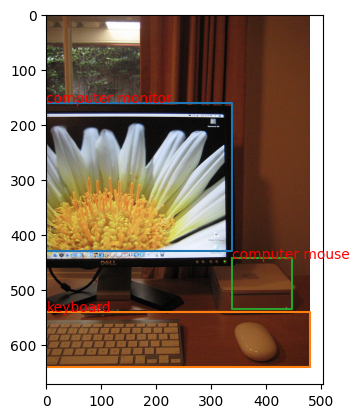

In [24]:
import matplotlib.pyplot as plt
image = Image.open(image_path)
plt.imshow(image)
for bbox in out:
    w, h = image.size
    # th, tw = thw
    th, tw = 1024, 1024
    x1, y1, x2, y2 = bbox['x1']/tw*w, bbox['y1']/th*h, bbox['x2']/tw*w, bbox['y2']/th*h
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1])
    plt.text(x1, y1, s=bbox['label'], c='red')
plt.show()

In [31]:
import gc
import time


def clear_memory():
    # Delete variables if they exist in the current global scope
    if "inputs" in globals():
        del globals()["inputs"]
    if "model" in globals():
        del globals()["model"]
    if "processor" in globals():
        del globals()["processor"]
    if "trainer" in globals():
        del globals()["trainer"]
    if "peft_model" in globals():
        del globals()["peft_model"]
    if "bnb_config" in globals():
        del globals()["bnb_config"]
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


clear_memory()

GPU allocated memory: 0.01 GB
GPU reserved memory: 0.02 GB


In [32]:
from transformers import BitsAndBytesConfig

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id, device_map="auto", torch_dtype=torch.bfloat16, quantization_config=bnb_config
)
processor = Qwen2VLProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [33]:
print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

GPU allocated memory: 5.53 GB
GPU reserved memory: 7.83 GB


In [34]:
from peft import LoraConfig, get_peft_model
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

trainable params: 2,523,136 || all params: 8,293,898,752 || trainable%: 0.0304


In [35]:
print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

GPU allocated memory: 5.54 GB
GPU reserved memory: 7.84 GB


In [36]:
from trl import SFTConfig

# Configure training arguments
training_args = SFTConfig(
    output_dir="qwen2-7b-instruct-trl-sft-ChartQA",  # Directory to save the model
    num_train_epochs=3,  # Number of training epochs
    per_device_train_batch_size=4,  # Batch size for training
    per_device_eval_batch_size=4,  # Batch size for evaluation
    gradient_accumulation_steps=8,  # Steps to accumulate gradients
    gradient_checkpointing=True,  # Enable gradient checkpointing for memory efficiency
    # Optimizer and scheduler settings
    optim="adamw_torch_fused",  # Optimizer type
    learning_rate=2e-4,  # Learning rate for training
    lr_scheduler_type="constant",  # Type of learning rate scheduler
    # Logging and evaluation
    logging_steps=10,  # Steps interval for logging
    eval_steps=10,  # Steps interval for evaluation
    eval_strategy="steps",  # Strategy for evaluation
    save_strategy="steps",  # Strategy for saving the model
    save_steps=20,  # Steps interval for saving
    metric_for_best_model="eval_loss",  # Metric to evaluate the best model
    greater_is_better=False,  # Whether higher metric values are better
    load_best_model_at_end=True,  # Load the best model after training
    # Mixed precision and gradient settings
    bf16=True,  # Use bfloat16 precision
    tf32=True,  # Use TensorFloat-32 precision
    max_grad_norm=0.3,  # Maximum norm for gradient clipping
    warmup_ratio=0.03,  # Ratio of total steps for warmup
    # Hub and reporting
    push_to_hub=False,  # Whether to push model to Hugging Face Hub
    report_to="wandb",  # Reporting tool for tracking metrics
    # Gradient checkpointing settings
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Options for gradient checkpointing
    # Dataset configuration
    dataset_text_field="",  # Text field in dataset
    dataset_kwargs={"skip_prepare_dataset": True},  # Additional dataset options
    # max_seq_length=1024  # Maximum sequence length for input
)

training_args.remove_unused_columns = False  # Keep unused columns in dataset

In [37]:
import wandb

wandb.init(
    project="qwen2-7b-instruct-trl-sft-ChartQA",  # change this
    name="qwen2-7b-instruct-trl-sft-ChartQA",  # change this
    config=training_args,
)

wandb: Currently logged in as: 2659814334 (hkguan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [38]:
# Create a data collator to encode text and image pairs
def collate_fn(examples):
    # Get the texts and images, and apply the chat template
    texts = [
        processor.apply_chat_template(example, tokenize=False) for example in examples
    ]  # Prepare texts for processing
    image_inputs = [process_vision_info(example)[0] for example in examples]  # Process the images to extract inputs

    # Tokenize the texts and process the images
    batch = processor(
        text=texts, images=image_inputs, return_tensors="pt", padding=True
    )  # Encode texts and images into tensors

    # The labels are the input_ids, and we mask the padding tokens in the loss computation
    labels = batch["input_ids"].clone()  # Clone input IDs for labels
    labels[labels == processor.tokenizer.pad_token_id] = -100  # Mask padding tokens in labels

    # Ignore the image token index in the loss computation (model specific)
    if isinstance(processor, Qwen2VLProcessor):  # Check if the processor is Qwen2VLProcessor
        image_tokens = [151652, 151653, 151655]  # Specific image token IDs for Qwen2VLProcessor
    else:
        image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]  # Convert image token to ID

    # Mask image token IDs in the labels
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100  # Mask image token IDs in labels

    batch["labels"] = labels  # Add labels to the batch

    return batch  # Return the prepared batch

In [39]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    processing_class=processor.tokenizer,
)

/home/huankguan2/projects/psor2025/finetune_vlm_trl/.venv/lib/python3.10/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/home/huankguan2/projects/psor2025/finetune_vlm_trl/.venv/lib/python3.10/site-packages/peft/tuners/tuners_utils.py:190: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [40]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
10,21.080600,2.122698


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.55 GiB. GPU 0 has a total capacity of 23.65 GiB of which 3.53 GiB is free. Including non-PyTorch memory, this process has 20.04 GiB memory in use. Of the allocated memory 15.88 GiB is allocated by PyTorch, and 3.70 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
trainer.save_model(training_args.output_dir)

In [ ]:
clear_memory()

In [ ]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

processor = Qwen2VLProcessor.from_pretrained(model_id)

In [ ]:
adapter_path = "sergiopaniego/qwen2-7b-instruct-trl-sft-ChartQA"
model.load_adapter(adapter_path)

In [ ]:
output = generate_text_from_sample(model, processor, test_dataset[10])
output

In [ ]:
from IPython.display import IFrame

IFrame(src="https://sergiopaniego-qwen2-vl-7b-trl-sft-chartqa.hf.space", width=1000, height=800)